In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from transformers import DeiTFeatureExtractor, DeiTModel
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [2]:
# Data Loading
train_labels = pd.read_csv(r"C:\Users\risha\Downloads\Project Task 1 (1)\train_labels.txt", header=None).values.flatten()
val_labels = pd.read_csv(r"C:\Users\risha\Downloads\Project Task 1 (1)\val_labels.txt", header=None).values.flatten()

image_folder_train = r"C:\Users\risha\Downloads\Project Task 1 (1)\train_data"
image_folder_val = r"C:\Users\risha\Downloads\Project Task 1 (1)\val_data"
train_image_paths = [os.path.join(image_folder_train, img) for img in os.listdir(image_folder_train)]
val_image_paths = [os.path.join(image_folder_val, img) for img in os.listdir(image_folder_val)]




In [3]:

num_classes = len(np.unique(train_labels))

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)

In [4]:
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
deit_model = DeiTModel.from_pretrained("facebook/deit-base-distilled-patch16-224")


c:\Users\risha\anaconda3\Lib\site-packages\transformers\models\deit\feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Image Preprocessing
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        inputs = feature_extractor(images=img, return_tensors="pt")
        with torch.no_grad():
            outputs = deit_model(**inputs)
            features = outputs.last_hidden_state[:, 0, :]
        images.append(features.squeeze(0).cpu().numpy())
    return np.array(images)

train_features = load_and_preprocess_images(train_image_paths)
val_features = load_and_preprocess_images(val_image_paths)

In [6]:
# Dataset and Dataloader
class CustomTensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1: Train Acc=0.0250, Val Acc=0.0617
Epoch 2: Train Acc=0.0497, Val Acc=0.1833
Epoch 3: Train Acc=0.0853, Val Acc=0.2750
Epoch 4: Train Acc=0.1267, Val Acc=0.3850
Epoch 5: Train Acc=0.1593, Val Acc=0.4200
Epoch 6: Train Acc=0.2203, Val Acc=0.4767
Epoch 7: Train Acc=0.2537, Val Acc=0.5167
Epoch 8: Train Acc=0.2803, Val Acc=0.5517
Epoch 9: Train Acc=0.3403, Val Acc=0.5700
Epoch 10: Train Acc=0.3700, Val Acc=0.6200
Epoch 11: Train Acc=0.3960, Val Acc=0.6450
Epoch 12: Train Acc=0.4200, Val Acc=0.6617
Epoch 13: Train Acc=0.4477, Val Acc=0.6800
Epoch 14: Train Acc=0.4733, Val Acc=0.6900
Epoch 15: Train Acc=0.4857, Val Acc=0.7117
Epoch 16: Train Acc=0.5190, Val Acc=0.7267
Epoch 17: Train Acc=0.5367, Val Acc=0.7350
Epoch 18: Train Acc=0.5657, Val Acc=0.7467
Epoch 19: Train Acc=0.5640, Val Acc=0.7633
Epoch 20: Train Acc=0.6007, Val Acc=0.7667
Epoch 21: Train Acc=0.6163, Val Acc=0.7833
Epoch 22: Train Acc=0.6140, Val Acc=0.7967
Epoch 23: Train Acc=0.6370, Val Acc=0.7967
Epoch 24: Train Acc=

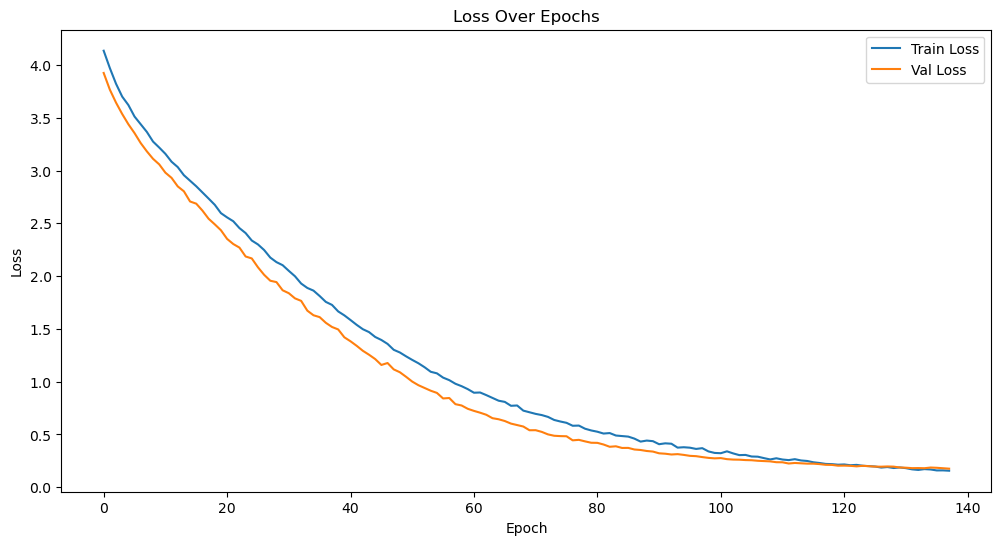

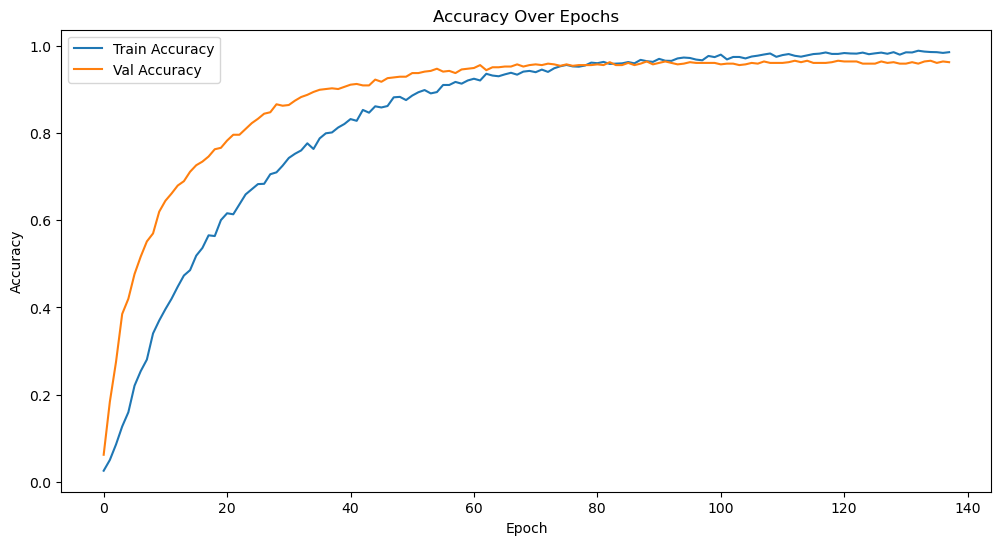

Best Validation Accuracy: 0.9666666666666667


In [7]:
# Convert to tensors
X_train = torch.tensor(train_features, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_val = torch.tensor(val_features, dtype=torch.float32)
y_val = torch.tensor(val_labels, dtype=torch.long)

# DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Model Definition
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
input_dim = train_features.shape[1]
dropout_rate = 0.3
learning_rate = 5e-5
patience = 25

# Initialize model, loss, optimizer
model = MLPClassifier(input_dim, num_classes, dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop with Early Stopping
best_val_acc = 0.0
epochs = 500
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

print("Best Validation Accuracy:", best_val_acc)

In [11]:
# Load and Preprocess Test Data
test_labels = pd.read_csv(r"C:\Users\risha\Downloads\Project Task 1 (1)\test_labels.txt", header=None).values.flatten()
image_folder_test = r"C:\Users\risha\Downloads\Project Task 1 (1)\test_data"
test_image_paths = [os.path.join(image_folder_test, img) for img in os.listdir(image_folder_test)]

# Use the same encoder to transform test labels
test_labels = encoder.transform(test_labels)

# Extract features
test_features = load_and_preprocess_images(test_image_paths)

# Convert to tensors
X_test = torch.tensor(test_features, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Test DataLoader
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

# Load Best Model for Evaluation
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Evaluate on Test Set
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9667


C:\Users\risha\AppData\Local\Temp\ipykernel_4556\4167404798.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
